# Modules Imports

In [234]:
# file management & data handling
import os, requests, zipfile
import pandas as pd

# plotting 
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from fa2 import ForceAtlas2
import matplotlib.colors as mcolors
import seaborn as sns

# computation & simulation
import numpy as np
import networkx as nx
import EoN

# Data Extraction

In [235]:
# creating the data directory 
if not os.path.exists("data"): os.makedirs("data")


# download files
if not os.path.exists(r"data\tij_InVS_.zip"):

    response = requests.get(url="http://www.sociopatterns.org/wp-content/uploads/2016/06/tij_InVS.dat_.zip")
    
    with open("data/tij_InVS.dat_.zip", "wb") as file:
        file.write(response.content)

if not os.path.exists(r"data\metadata_InVS13.txt"):

    response = requests.get(url="http://www.sociopatterns.org/wp-content/uploads/2016/06/metadata_InVS13.txt")
    
    with open("data/metadata_InVS13.txt", "wb") as file:
        file.write(response.content)


# unzip data
if not os.path.exists(r"data\tij_InVS.dat"):

    with zipfile.ZipFile(file='data/tij_InVS.dat_.zip', mode='r') as file:
        file.extractall(path='data')

# Aggregated Network Graph

## Data Processing

In [236]:
# read data
raw_data_df = pd.read_csv(
    filepath_or_buffer=r'data/tij_InVS.dat',
    sep=' ',
    header=None
    ).rename(
        columns={0: 'TIME', 1: 'FROM', 2: 'TO'}
        )

# compute edges weights
aggregated_data_df = raw_data_df.groupby(['FROM', 'TO'], as_index=False).size().rename(columns={'size' : 'WEIGHT'})

# read metadata 
metadata_df = pd.read_csv(
    filepath_or_buffer=r"data/metadata_InVS13.txt",
    sep='\t',
    header=None    
    ).rename(
        columns={0: 'ID', 1: 'DEPARTMENT'}
        )
    
display(aggregated_data_df)

,FROM,TO,WEIGHT
0,15,29,2
1,15,95,80
2,15,123,37
3,15,223,8
4,15,253,41
...,...,...,...
750,804,938,9
751,819,939,9
752,819,987,5
753,826,987,1


## Graph Visualisation

100%|██████████| 2000/2000 [00:00<00:00, 2290.64it/s]


BarnesHut Approximation  took  0.14  seconds
Repulsion forces  took  0.60  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


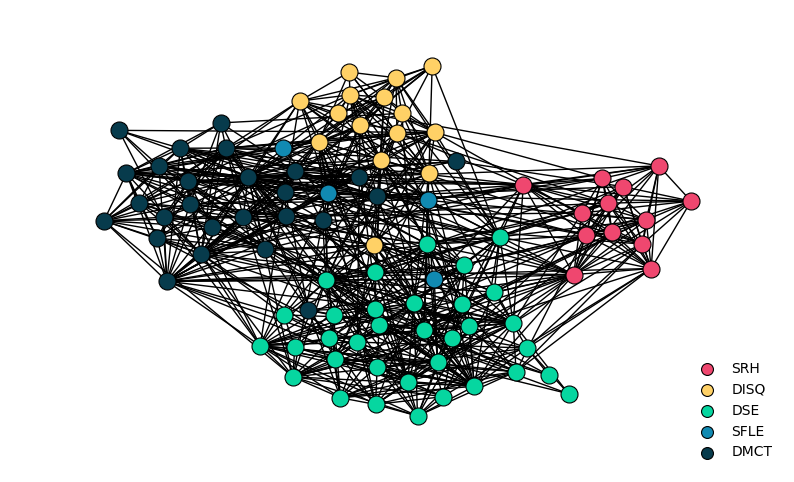

In [237]:
# graph initilisation
G = nx.Graph()

# add nodes to graph
nodes_list = list(set(aggregated_data_df[['FROM', 'TO']].values.ravel().tolist()))
nodes_labels_dict = {'SRH': [], 'DISQ': [], 'DSE': [], 'SFLE': [], 'DMCT': []}

for node in nodes_list:
    
    G.add_node(node_for_adding=node)
    
    # get nodes labels
    node_label = metadata_df.loc[metadata_df['ID'] == node, 'DEPARTMENT'].item()
    nodes_labels_dict[node_label] += [node]
    

# add edges to graph
edges_list = list(zip(aggregated_data_df.FROM, aggregated_data_df.TO, aggregated_data_df.WEIGHT))

for edge in edges_list:
    
    u, v, weight = edge
    
    G.add_edge(u, v, weight=weight)


# plot graph
color_map = {
    'SRH': '#ef476f',
    'DISQ': '#ffd166',
    'DSE': '#06d6a0',
    'SFLE': '#118ab2',
    'DMCT': '#073b4c'
    }

# Force Atlas algorithm layout
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

# create the figure
fig, ax = plt.subplots(figsize=(10,6))

for label, color in color_map.items():
    
    nx.draw_networkx_nodes(G=G, 
                           pos=pos,
                           ax=ax,
                           nodelist=nodes_labels_dict[label],
                           node_color=color,
                           node_size=150,
                           edgecolors='black',
                           linewidths=0.8,
                           label=label,
                           margins=0.1
                           )


nx.draw_networkx_edges(G=G,
                       pos=pos,
                       edgelist=edges_list
                       )


legend = ax.legend(loc="lower right",
          frameon=False,
          markerscale=0.7);

plt.axis('off')


# creating the data directory 
if not os.path.exists("figures"): os.makedirs("figures")

plt.savefig('figures/aggregated_graph.pdf', bbox_inches='tight')

# Degrees

## Distribution

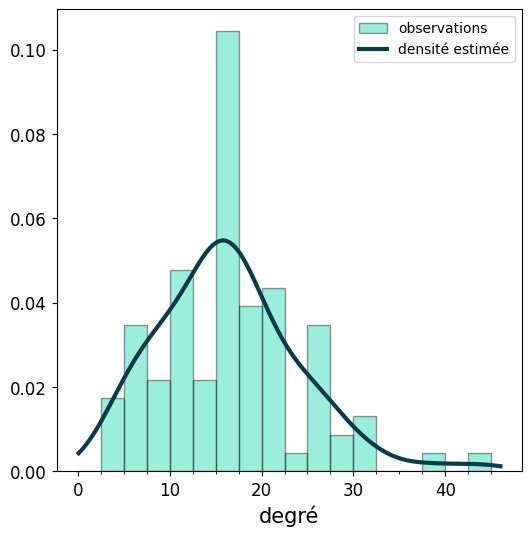

In [238]:
# compute normalized degrees 
nodes_number = G.number_of_nodes()
degrees_list = [x[1] for x in G.degree()]
average_node_degree = sum(degrees_list)/nodes_number
normalized_degrees_list = [x / average_node_degree for x in degrees_list]

fig, ax = plt.subplots(figsize=(6, 6))

# plot histogram
ax.hist(x=degrees_list,
        density=True,
        bins=np.arange(0, 46, 2.5).tolist(),
        color='#06d6a0',
        edgecolor='black',
        alpha=0.4,
        label='observations'
        )

# plot kernel density estimate
sns.kdeplot(
        data=degrees_list,
        clip=(0.1,46),
        color='#073b4c',
        linewidth=3,
        label='densité estimée',
        ax=ax
        )


# minor_ticks = np.arange(0, 3.1, 0.125)
minor_ticks = np.arange(0, 46, 2.5)
ax.set_xticks(minor_ticks, minor=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# xlabels = [round(x) if x.is_integer() else x for x in np.arange(start=0, stop=3.1, step=0.5)]
# ax.set_xticklabels(xlabels)

# ylabels = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]
# ax.set_yticklabels(ylabels)


# ax.set_xlim(xmin=0, xmax=3)
# ax.set_xlabel(xlabel='degré normalisé')
ax.set_xlabel(xlabel='degré', fontsize=15)
ax.set_ylabel(ylabel=None)
ax.legend()

# plt.savefig('figures/normalized_degree_distribution', format='pdf', bbox_inches='tight')
plt.savefig('figures/degree_distribution.pdf', bbox_inches='tight')

##  Graph

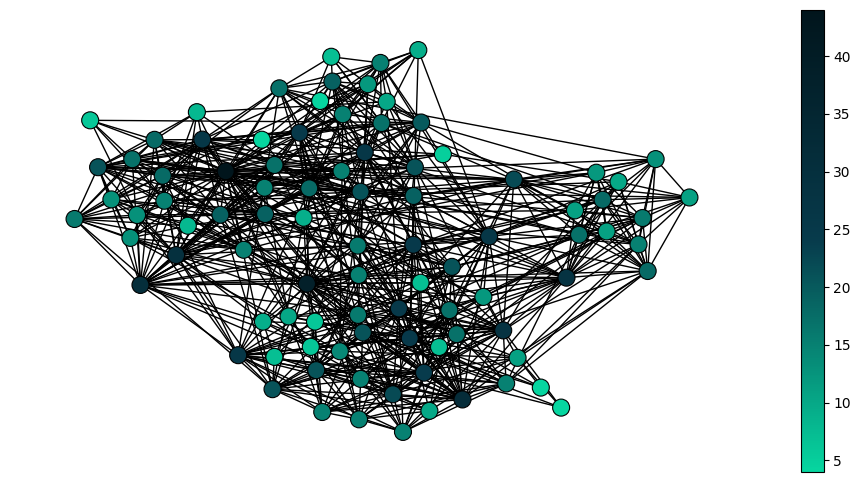

In [239]:
network_custom_cmap = mcolors.LinearSegmentedColormap\
                             .from_list(
                                 name='custom',
                                 colors=['#06d6a0', '#073b4c', '#01151c']
                                 )
                             
nodes = G.nodes()

fig, ax = plt.subplots(figsize=(12,6))

plot = nx.draw_networkx_nodes(
        G, 
        pos=pos,
        nodelist=nodes,
        node_color=degrees_list,
        node_size=150,
        edgecolors='black',
        linewidths=0.8,
        # margins=0.1,        
        # cmap='viridis',
        cmap=network_custom_cmap,
        ax=ax
        )

nx.draw_networkx_edges(G=G,
                       pos=pos,
                       edgelist=edges_list
                       )
plt.axis('off')


fig.colorbar(plot)
# fig.colorbar(plot).set_label(label='degré', size=15)

plt.savefig('figures/degrees_graph.pdf', bbox_inches='tight')

## Average Node Degree

In [240]:
print(average_node_degree)

16.41304347826087


# Betweeness Centrality

## Distribution

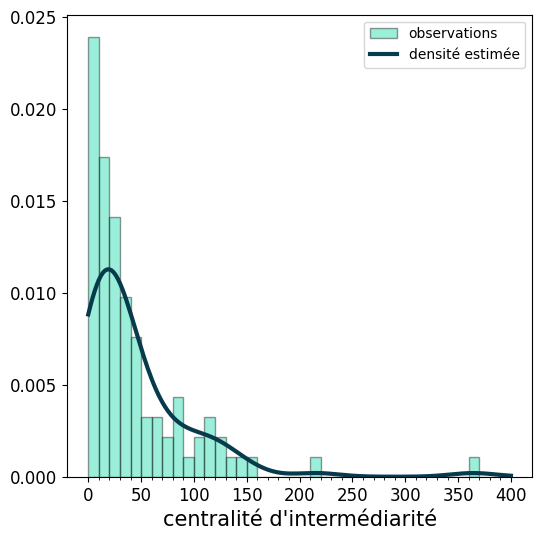

In [241]:
betweenness_centralities_list = list(nx.betweenness_centrality(G, normalized=False).values())

fig, ax = plt.subplots(figsize=(6, 6))

# plot histogram
ax.hist(
    x=betweenness_centralities_list,
    density=True,
    bins=np.arange(0, 401, 10).tolist(),
    color='#06d6a0',
    edgecolor='black',
    alpha=0.4,
    label='observations'
    )

# plot kernel density estimate
sns.kdeplot(
    data=betweenness_centralities_list,
    clip=(0,400),
    color='#073b4c',
    linewidth=3,
    label='densité estimée',
    ax=ax
    )

minor_ticks = np.arange(0, 401, 10)
ax.set_xticks(minor_ticks, minor=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel(xlabel='centralité d\'intermédiarité', fontsize=15)
ax.set_ylabel(ylabel=None)
ax.legend()

plt.savefig('figures/betweenness_centrality_distribution.pdf', bbox_inches='tight')


## Graph

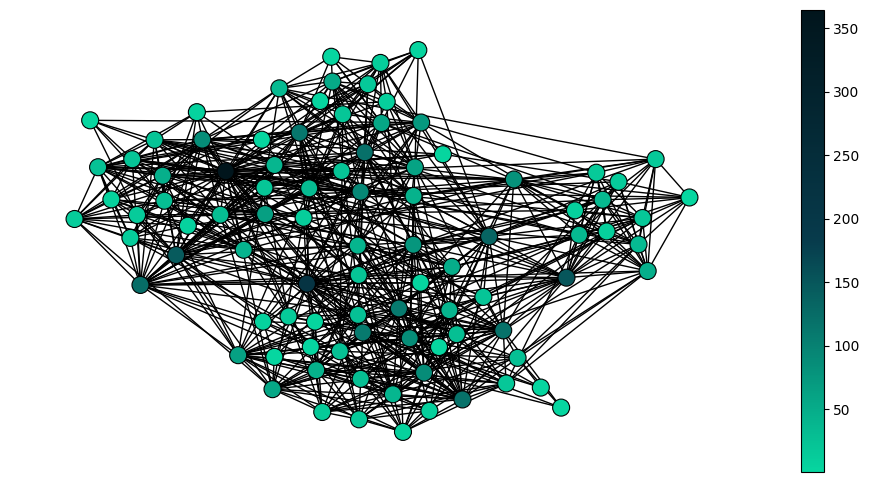

In [242]:
fig, ax = plt.subplots(figsize=(12,6))

plot = nx.draw_networkx_nodes(
        G, 
        pos=pos,
        nodelist=nodes,
        node_color=betweenness_centralities_list,
        node_size=150,
        edgecolors='black',
        linewidths=0.8,
        # margins=0.1,        
        # cmap='viridis',
        cmap=network_custom_cmap,
        ax=ax
        )

nx.draw_networkx_edges(G=G,
                       pos=pos,
                       edgelist=edges_list
                       )
plt.axis('off')

fig.colorbar(plot)
# fig.colorbar(plot).set_label(label='centralité d\'intermédiarité', size=15)

plt.savefig('figures/betweenness_centrality_graph.pdf', bbox_inches='tight')

# Eigenvector Centrality

## Distribution

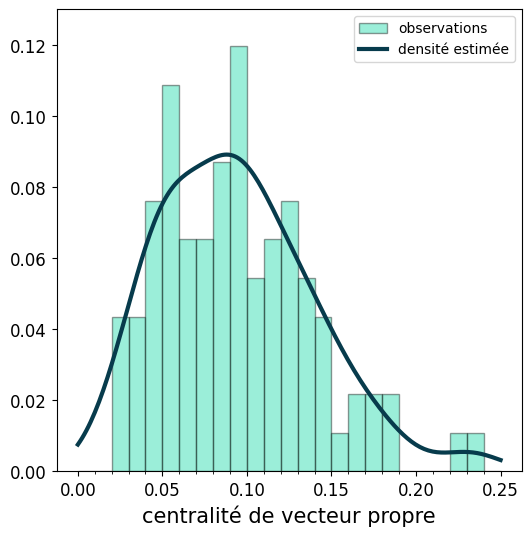

In [243]:
eigenvector_centralities = nx.eigenvector_centrality(G)
eigenvector_centralities_list = list(eigenvector_centralities.values())

fig, ax = plt.subplots(figsize=(6, 6))

# plot histogram
ax.hist(
    x=eigenvector_centralities_list,
    weights=np.ones_like(eigenvector_centralities_list)/len(eigenvector_centralities_list),
    bins=np.arange(0, 0.26, 0.01).tolist(),
    color='#06d6a0',
    edgecolor='black',
    alpha=0.4,
    label='observations'
    )

# plot kernel density estimate
sns.kdeplot(
    data=eigenvector_centralities_list,
    clip=(0,0.25),
    color='#073b4c',
    linewidth=3,
    label='densité estimée',
    ax=ax
    )

# rescaling the density plot (fixing kdeplot display bug)
ax.get_lines()[0].set_ydata(ax.get_lines()[0].get_ydata()/len(eigenvector_centralities_list))

minor_ticks = np.arange(0, 0.26, 0.01)
ax.set_xticks(minor_ticks, minor=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0,0.13)

ax.set_xlabel(xlabel='centralité de vecteur propre', fontsize=15)
ax.set_ylabel(ylabel=None)
ax.legend()

plt.savefig('figures/eigenvector_centrality_distribution.pdf', bbox_inches='tight')

## Graph

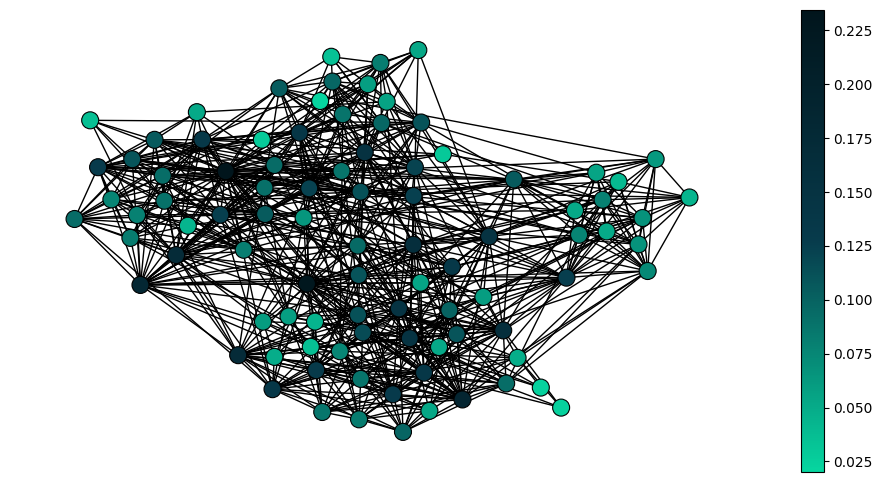

In [244]:
fig, ax = plt.subplots(figsize=(12,6))

plot = nx.draw_networkx_nodes(
        G, 
        pos=pos,
        nodelist=nodes,
        node_color=eigenvector_centralities_list,
        node_size=150,
        edgecolors='black',
        linewidths=0.8,
        # margins=0.1,        
        # cmap='viridis',
        cmap=network_custom_cmap,
        ax=ax
        )

nx.draw_networkx_edges(G=G,
                       pos=pos,
                       edgelist=edges_list
                       )
plt.axis('off')


fig.colorbar(plot)
# fig.colorbar(plot).set_label(label='centralité de vecteur propre', size=15)

plt.savefig('figures/eigenvector_centrality_graph.pdf', bbox_inches='tight')

# Edges Weights 

## Distribution

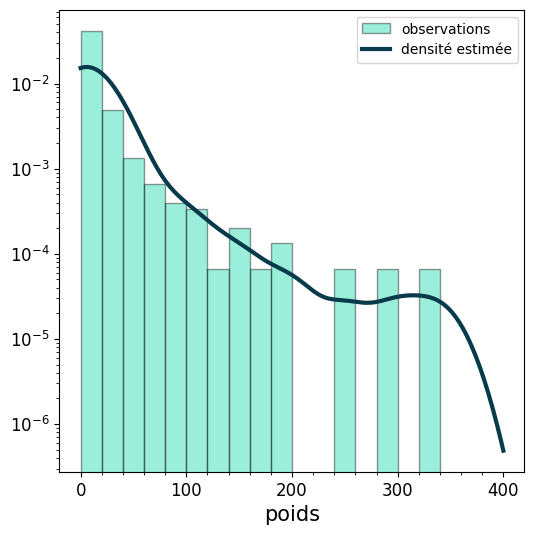

In [245]:
# get edges weights
weights_list = []
for edge in G.edges(data=True): 
    
    weights_list.append(G.get_edge_data(*edge)['weight'])

    
fig, ax = plt.subplots(figsize=(6,6))

# plot histogram
ax.hist(weights_list,
        bins=[*range(0, 401, 20)],
        density=True,
        color='#06d6a0',
        edgecolor='black',
        alpha=0.4,
        label='observations'
        )

# plot kernel density estimate
sns.kdeplot(data=[weight for weight in weights_list if weight <= 400],
            clip=(0,400),
            bw_adjust=3,
            color='#073b4c',
            linewidth=3,
            label='densité estimée',
            ax=ax,
            )

major_ticks = np.arange(0,401, 100)
ax.set_xticks(major_ticks)

minor_ticks = np.arange(0,401,20)
ax.set_xticks(minor_ticks, minor=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.set_yscale('log')
ax.set_xlabel(xlabel='poids', fontsize=15)
ax.set_ylabel(ylabel=None)
ax.legend()

plt.savefig('figures/weight_distribution.pdf', bbox_inches='tight')


# Contact Matrix

C:\Users\lucas\AppData\Local\Temp\ipykernel_16872\434929039.py:22: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  contact_matrix = nx.adjacency_matrix(G=Contact_Matrix_Graph,


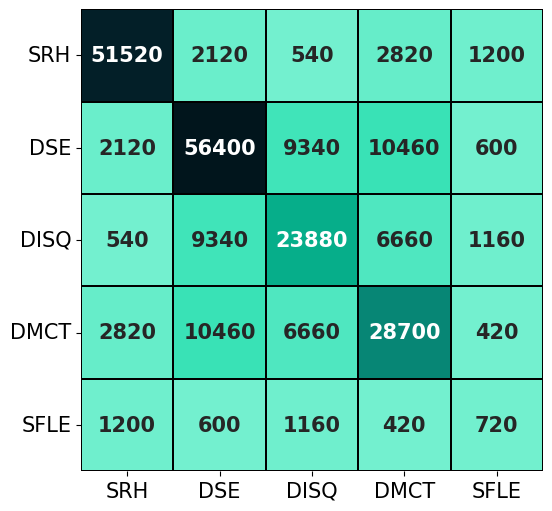

In [246]:
# graph aggregated by department
Contact_Matrix_Graph = nx.Graph()

department_names_list = list(nodes_labels_dict)
nodes_department_dict = dict(zip(metadata_df.ID, metadata_df.DEPARTMENT))

for department in department_names_list:
    
    Contact_Matrix_Graph.add_node(department)
      
for edge in edges_list:
    
    (u, v, weight) = edge
    u, v = nodes_department_dict[u], nodes_department_dict[v]
    
    if not Contact_Matrix_Graph.has_edge(u, v): Contact_Matrix_Graph.add_edge(u, v, weight=weight)
        
    else: Contact_Matrix_Graph[u][v]['weight'] += weight


# contact matrix
contact_matrix = nx.adjacency_matrix(G=Contact_Matrix_Graph, 
                                     nodelist=['SRH','DSE','DISQ','DMCT','SFLE']
                                     )\
                                    .todense()
contact_matrix *= 20

# create the figure
fig, ax = plt.subplots(figsize=(10,6))

# custom colormap
contact_matrix_custom_cmap = mcolors.LinearSegmentedColormap\
                .from_list(
                    name='custom',
                    colors=['#73f0cf', '#06d6a0', '#073b4c', '#01151c']
                    )

# plot the contact matrix
heatmap = sns.heatmap(
            data=contact_matrix,
            cmap=contact_matrix_custom_cmap,
            square=True,
            annot=True,
            annot_kws={'size': 15, "weight": "bold"},
            fmt=".0f",
            cbar=False,
            linewidths=0.01,
            linecolor='black',
            xticklabels=['SRH','DSE','DISQ','DMCT','SFLE'],
            yticklabels=['SRH','DSE','DISQ','DMCT','SFLE'],
            ax=ax
            )


ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('figures/contact_matrix.pdf', bbox_inches='tight')

# Epidemic Processes Analysis

## Discrete-Time Random walks

In [247]:
def random_walk(G: nx.classes.graph.Graph, n_steps: int, start_node, walk_type: str):
    
    current_node = start_node
    walk_nodes_list = [None] * (n_steps+1)
    walk_nodes_list[0] = start_node
    
    for i in range(1, n_steps+1):
        
        current_node_neighbors_list = list(G.neighbors(current_node))
        
        match walk_type:
            
            # each neighbor has the same probabilty of being drawn
            case 'uniform': current_node = np.random.choice(current_node_neighbors_list)

            # neighbor with greater weights are drawn with a higher probability
            case 'contact_time': 
                
                weights_list = [G.edges[(current_node,i)]['weight'] for i in current_node_neighbors_list]
                
                # computing drawing probabilities
                sum_weights = sum(weights_list)
                draw_probabilities = [weight/sum_weights for weight in weights_list]
                
                # drawing the next node
                drawed_neighbor_index = np.random.choice(np.arange(len(current_node_neighbors_list)), p=draw_probabilities)
                current_node = current_node_neighbors_list[drawed_neighbor_index]
                
        walk_nodes_list[i] = current_node
    
    return walk_nodes_list


def random_walks_network_coverage(G: nx.classes.graph.Graph, walk_type: str, max_steps: int, steps_size: int, start_node=None):

    # draws random starting node if none is given
    if start_node is None : start_node = np.random.choice(list(G.nodes()))
    
    steps_list = [*range(0, max_steps+1, steps_size)]
    simulation_results_list = [None] * len(steps_list)
    
    # compute network coverage ratios
    for index, n_steps in enumerate(steps_list):

        random_walk_nodes_list = random_walk(G=G, 
                                            n_steps=n_steps, 
                                            start_node=start_node,
                                            walk_type=walk_type
                                            )

        covered_nodes_number = len(set(random_walk_nodes_list))
        network_coverage_ratio = covered_nodes_number/nodes_number*100
        
        simulation_results_list[index] = network_coverage_ratio
        
        
    return simulation_results_list

# random walks simulations settings
max_steps = 1000
steps_size = 50
steps_list = [*range(0, max_steps+1, steps_size)]
n_sims = 10

### Uniform Probabilities

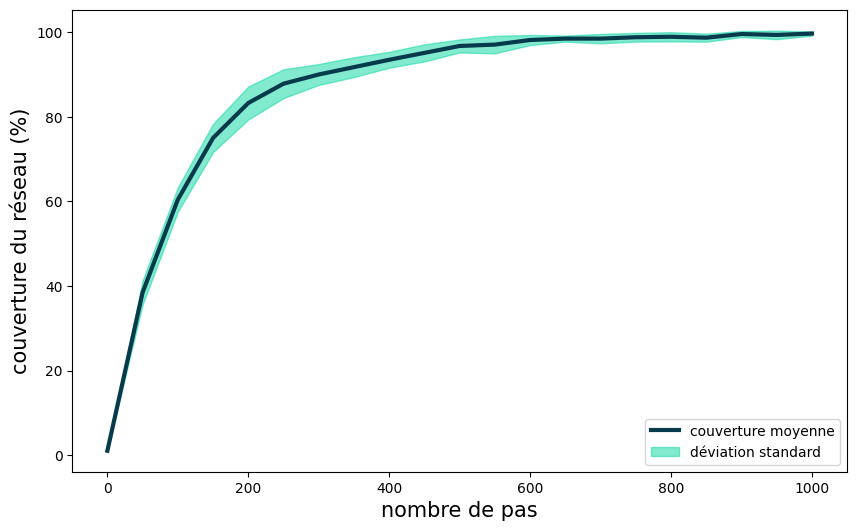

In [248]:
walk_type = 'uniform'
simulations = np.zeros(shape=(n_sims, int(max_steps/steps_size)+1))

for sim in range(0, n_sims):

    simulations[sim] = random_walks_network_coverage(
                                G=G,
                                walk_type=walk_type,
                                max_steps=max_steps,
                                steps_size=steps_size
                                )


average_coverage_ratio = np.mean(a=simulations, axis=0)
std_coverage_ratio = np.std(a=simulations, axis=0)

# plotting simulations results
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(steps_list, average_coverage_ratio, 
        color='#073b4c', linewidth=3,
        label='couverture moyenne'
        )


ax.fill_between(steps_list, average_coverage_ratio - std_coverage_ratio, average_coverage_ratio + std_coverage_ratio, 
                color='#06d6a0', alpha=0.5,
                label='déviation standard'
                )

ax.set_xlabel(xlabel='nombre de pas', fontsize=15)
ax.set_ylabel(ylabel='couverture du réseau (%)', fontsize=15)
ax.legend(loc='lower right')

plt.savefig('figures/network_coverage_uniform_walks.pdf', bbox_inches='tight')


### Contact-Time Based Probabilities

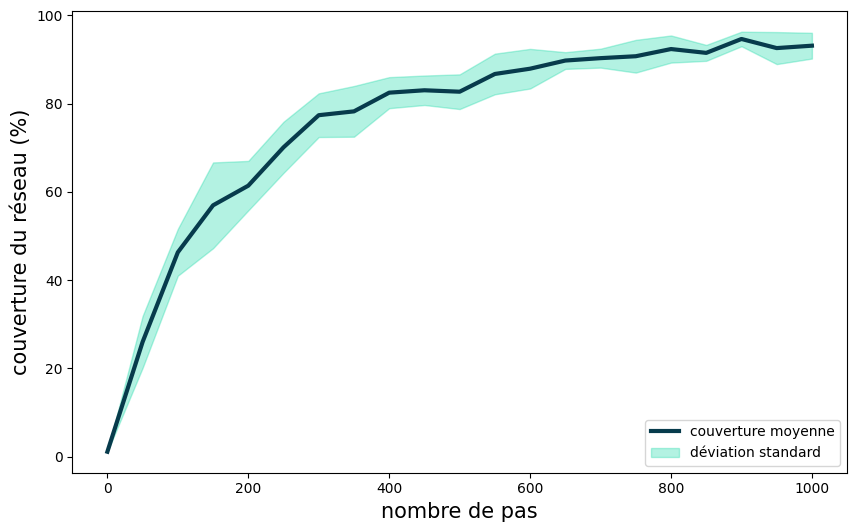

In [249]:
walk_type = 'contact_time'
simulations = np.zeros(shape=(n_sims, int(max_steps/steps_size)+1))

for sim in range(0, n_sims):

    simulations[sim] = random_walks_network_coverage(
                                G=G,
                                walk_type=walk_type,
                                max_steps=max_steps,
                                steps_size=steps_size
                                )


average_coverage_ratio = np.mean(a=simulations, axis=0)
std_coverage_ratio = np.std(a=simulations, axis=0)

# plotting simulations results
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(steps_list, average_coverage_ratio, 
        color='#073b4c', linewidth=3,
        label='couverture moyenne'
        )

ax.fill_between(steps_list, average_coverage_ratio - std_coverage_ratio, average_coverage_ratio + std_coverage_ratio, 
                color='#06d6a0', alpha=0.3,
                label='déviation standard'
                )

ax.set_xlabel(xlabel='nombre de pas', fontsize=15)
ax.set_ylabel(ylabel='couverture du réseau (%)', fontsize=15)
ax.legend(loc='lower right')

plt.savefig('figures/network_coverage_contact_time_walks.pdf', bbox_inches='tight')


## Epidemic Processes Models

In [250]:
def merge_numpy_arrays(numpy_arrays_list):

    biggest_size = 0
    for nparray in numpy_arrays_list: biggest_size = max(nparray.size, biggest_size)

    # intilialize nparray of len(SIR_times_list) x biggest_size
    merged_numpy_arrays = np.zeros(shape=(len(numpy_arrays_list), biggest_size))

    # place values
    for index, nparray in enumerate(numpy_arrays_list):
        
        # nparray last element
        last_element = nparray[-1]

        # replace & repeat last value
        merged_numpy_arrays[index] = np.concatenate((nparray, np.full(shape=biggest_size-nparray.size, fill_value=last_element)))

    return merged_numpy_arrays


# simulations settings
p = 0.4
tmax = 30
n_sims = 10

### SIS Model

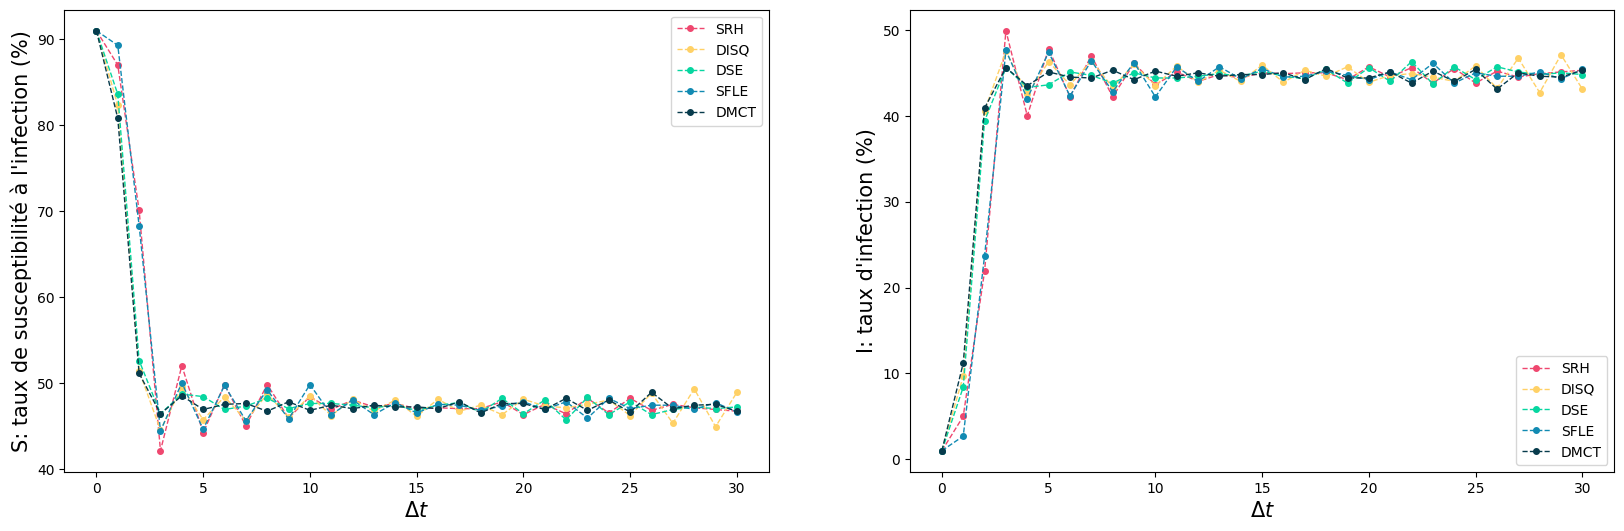

In [252]:
# intialize simulation results
S = np.zeros(shape=(n_sims, tmax+1))
I = np.zeros(shape=(n_sims, tmax+1))
t = np.arange(0,tmax+1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# drawing random infected node from each department
infected_nodes_dict = {}
for key in nodes_labels_dict: infected_nodes_dict[key] = np.random.choice(a=nodes_labels_dict[key])

# SIR single simulation 
for key, value in infected_nodes_dict.items():
    
    for sim in range(n_sims):
    
        _, S[sim], I[sim] = EoN.basic_discrete_SIS(G, p=p, initial_infecteds=value, tmax=tmax)
        # _, S_current, I_current = EoN.basic_discrete_SIS(G, p=p, initial_infecteds=value, tmax=tmax)
        
        # print(f'S_current: {S_current}')
        # print(f'I_current: {I_current}')
            
        # S[sim] = S_current
        # I[sim] = I_current
    
    S_mean = np.mean(a=S, axis=0)
    I_mean = np.mean(a=I, axis=0)
    
    ax[0].plot(t, S_mean, linestyle = 'dashed', linewidth=1, marker = 'o', markersize=4, color=color_map[key], label=key)
    ax[1].plot(t, I_mean, linestyle = 'dashed', linewidth=1, marker = 'o', markersize=4, color=color_map[key], label=key)    
    


ax[0].legend(loc='upper right')
ax[1].legend(loc='lower right')

ax[0].set_xlabel(xlabel=r'$\Delta t$', fontsize=15)
ax[0].set_ylabel(ylabel='S: taux de susceptibilité à l\'infection (%)', fontsize=15)

ax[1].set_xlabel(xlabel=r'$\Delta t$', fontsize=15)
ax[1].set_ylabel(ylabel='I: taux d\'infection (%)', fontsize=15)

plt.savefig(f'figures/SIS_model_p={p}.pdf', bbox_inches='tight')

### SIR Model

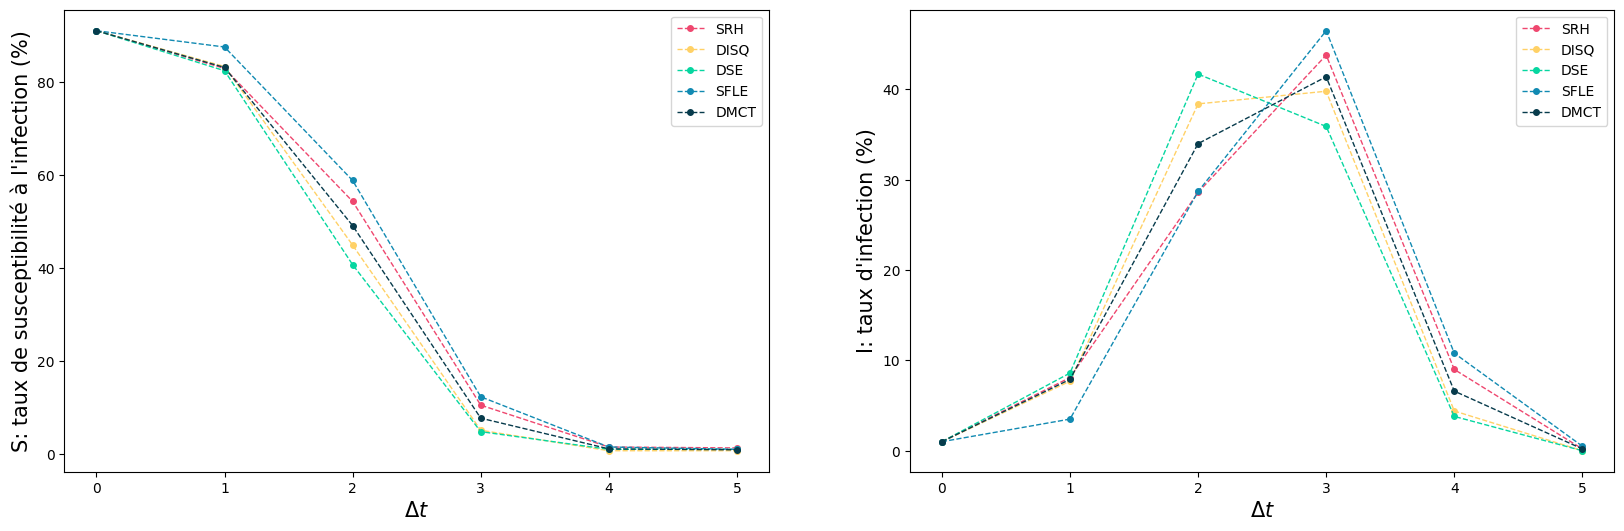

In [ ]:
tmax = 5

# intialize simulation results
S = np.zeros(shape=(n_sims, tmax+1))
I = np.zeros(shape=(n_sims, tmax+1))
t = np.arange(0,tmax+1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# drawing random infected node from each department
infected_nodes_dict = {}
for key in nodes_labels_dict: infected_nodes_dict[key] = np.random.choice(a=nodes_labels_dict[key])

# SIR single simulation 
for key, value in infected_nodes_dict.items():
    
    for sim in range(n_sims):
    
        _, S[sim], I[sim], _ = EoN.basic_discrete_SIR(G, p=p, initial_infecteds=value, tmax=tmax)
        # _, S_current, I_current = EoN.basic_discrete_SIS(G, p=p, initial_infecteds=value, tmax=tmax)
        
        # print(f'S_current: {S_current}')
        # print(f'I_current: {I_current}')
            
        # S[sim] = S_current
        # I[sim] = I_current
    
    S_mean = np.mean(a=S, axis=0)
    I_mean = np.mean(a=I, axis=0)
    
    ax[0].plot(t, S_mean, linestyle = 'dashed', linewidth=1, marker = 'o', markersize=4, color=color_map[key], label=key)
    ax[1].plot(t, I_mean, linestyle = 'dashed', linewidth=1, marker = 'o', markersize=4, color=color_map[key], label=key)    
    


ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

ax[0].set_xlabel(xlabel=r'$\Delta t$', fontsize=15)
ax[0].set_ylabel(ylabel='S: taux de susceptibilité à l\'infection (%)', fontsize=15)

ax[1].set_xlabel(xlabel=r'$\Delta t$', fontsize=15)
ax[1].set_ylabel(ylabel='I: taux d\'infection (%)', fontsize=15)

plt.savefig(f'figures/SIR_model_p={p}.pdf', bbox_inches='tight')